In [96]:
import os
import shutil
import json
import yaml
import random
import pandas as pd

mid = 318
e = 80

# 加载COCO标注文件
coco_path = fr'C:\data\program\python\CowBoy\test\add_json/all_json.json' 
image_dir_path = fr'C:\data\program\python\CowBoy\test\add/'
data = json.load(open(coco_path, 'r'))
ann = data['annotations']
random.seed(34)
random.shuffle(ann)

In [97]:
images_infos = data['images']
# 获取该图像的标注信息
annotations = data['annotations']

# 获取所有类别信息
categories = data['categories']
for i in range(len(annotations)):
    annotations[i]['id'] = i
print(annotations[0]['id'], annotations[-1]['id'])
len(annotations)

0 15808


15809

In [98]:
# ci = [0, 1, 2, 3, 4]  # category_id, 分别对应belt,sunglasses,boot,cowboy_hat,jacket
ci = [87,1034,131,318,588] 
print('total:')
for i in ci:
    count = 0
    for j in ann:
        if j['category_id'] == i:
            count += 1
    print(f'id: {i} counts: {count}')

total:
id: 87 counts: 2025
id: 1034 counts: 2330
id: 131 counts: 4019
id: 318 counts: 5240
id: 588 counts: 2195


In [99]:
total_id = set(each['image_id'] for each in ann)
val_id = set()
a, b, c, d, e = 0, 0, 0, 0, 0  # 用于每类的计数
for each in ann:
    if (each['category_id'] == ci[0]) and (a < 50):
        val_id.add(each['image_id'])
        a += 1
    elif (each['category_id'] == ci[1]) and (b < 50):
        val_id.add(each['image_id'])
        b += 1
    elif (each['category_id'] == ci[2]) and (c < 50):
        val_id.add(each['image_id'])
        c += 1
    elif (each['category_id'] == ci[3]) and (d < 50):
        val_id.add(each['image_id'])
        d += 1
    elif (each['category_id'] == ci[4]) and (e < 50):
        val_id.add(each['image_id'])
        e += 1

val_ann = []
for imid in val_id:
    for each_ann in ann:
        if each_ann['image_id'] == imid:
            val_ann.append(each_ann)
            
len(val_id),len(val_ann)

(247, 769)

In [100]:
print('val set:')
for kind in ci:
    num = 0
    for i in val_ann:
        if i['category_id'] == kind:
            num += 1
    print(f'id: {kind} counts: {num}')

val set:
id: 87 counts: 65
id: 1034 counts: 140
id: 131 counts: 214
id: 318 counts: 178
id: 588 counts: 172


In [101]:
# The rest images are for training
train_id = total_id - val_id
train_ann = []
for each_ann in ann:
    for tid in train_id:
        if each_ann['image_id'] == tid:
            train_ann.append(each_ann)
            break
len(train_id), len(train_ann)

(8911, 15040)

In [102]:
os.makedirs('./data/images/train', exist_ok=True)
os.makedirs('./data/images/val', exist_ok=True)
img_dir = image_dir_path
          
train_img = []
# Move train images
for j in data['images']:
    for i in train_id:
        if j['id'] == i:
            shutil.copy(img_dir+j['file_name'], './data/images/train')
            train_img.append(j)
            
val_img = []
# Move val images
for j in data['images']:
    for i in val_id:
        if j['id'] == i:
            shutil.copy(img_dir+j['file_name'], './data/images/val')
            val_img.append(j)

len(val_img), len(train_img)

(247, 8911)

In [103]:
os.makedirs('./data/labels/train', exist_ok=True)
os.makedirs('./data/labels/val', exist_ok=True)

train_info = [(each['id'], each['file_name'].split('.')[0], each['width'], each['height']) for each in train_img]
val_info = [(each['id'], each['file_name'].split('.')[0], each['width'], each['height']) for each in val_img]

trans = {f'{each}': f'{idx}' for (idx, each) in enumerate(ci)}  
print(trans)

# Create *.txt files for training
for (imid, fn, w, h) in train_info:
    with open('./data/labels/train/' + fn + '.txt', 'w') as t_f:
        for t_ann in train_ann:
            if t_ann['image_id'] == imid:
                # Convert bbox (X_min, Y_min, width, height) to YOLO format (X_center, Y_center, width, height)
                x_center = min(max((t_ann['bbox'][0] + t_ann['bbox'][2] / 2) / float(w), 0), 1)
                y_center = min(max((t_ann['bbox'][1] + t_ann['bbox'][3] / 2) / float(h), 0), 1)
                width = min(max(t_ann['bbox'][2] / float(w), 0), 1)
                height = min(max(t_ann['bbox'][3] / float(h), 0), 1)


                # Write to file in YOLO format
                label = str(int(trans[str(t_ann['category_id'])]))  # Category ID
                bbox = f"{x_center} {y_center} {width} {height}\n"
                t_f.write(f"{label} {bbox}")

# Create *.txt files for evaluating
for (imid, fn, w, h) in val_info:
    with open('./data/labels/val/' + fn + '.txt', 'w') as v_f:
        for v_ann in val_ann:
            if v_ann['image_id'] == imid:
                # Convert bbox (X_min, Y_min, width, height) to YOLO format (X_center, Y_center, width, height)
                x_center = min(max((v_ann['bbox'][0] + v_ann['bbox'][2] / 2) / float(w), 0), 1)
                y_center = min(max((v_ann['bbox'][1] + v_ann['bbox'][3] / 2) / float(h), 0), 1)
                width = min(max(v_ann['bbox'][2] / float(w), 0), 1)
                height = min(max(v_ann['bbox'][3] / float(h), 0), 1)


                # Write to file in YOLO format
                label = str(int(trans[str(v_ann['category_id'])]))  # Category ID
                bbox = f"{x_center} {y_center} {width} {height}\n"
                v_f.write(f"{label} {bbox}")


{'87': '0', '1034': '1', '131': '2', '318': '3', '588': '4'}


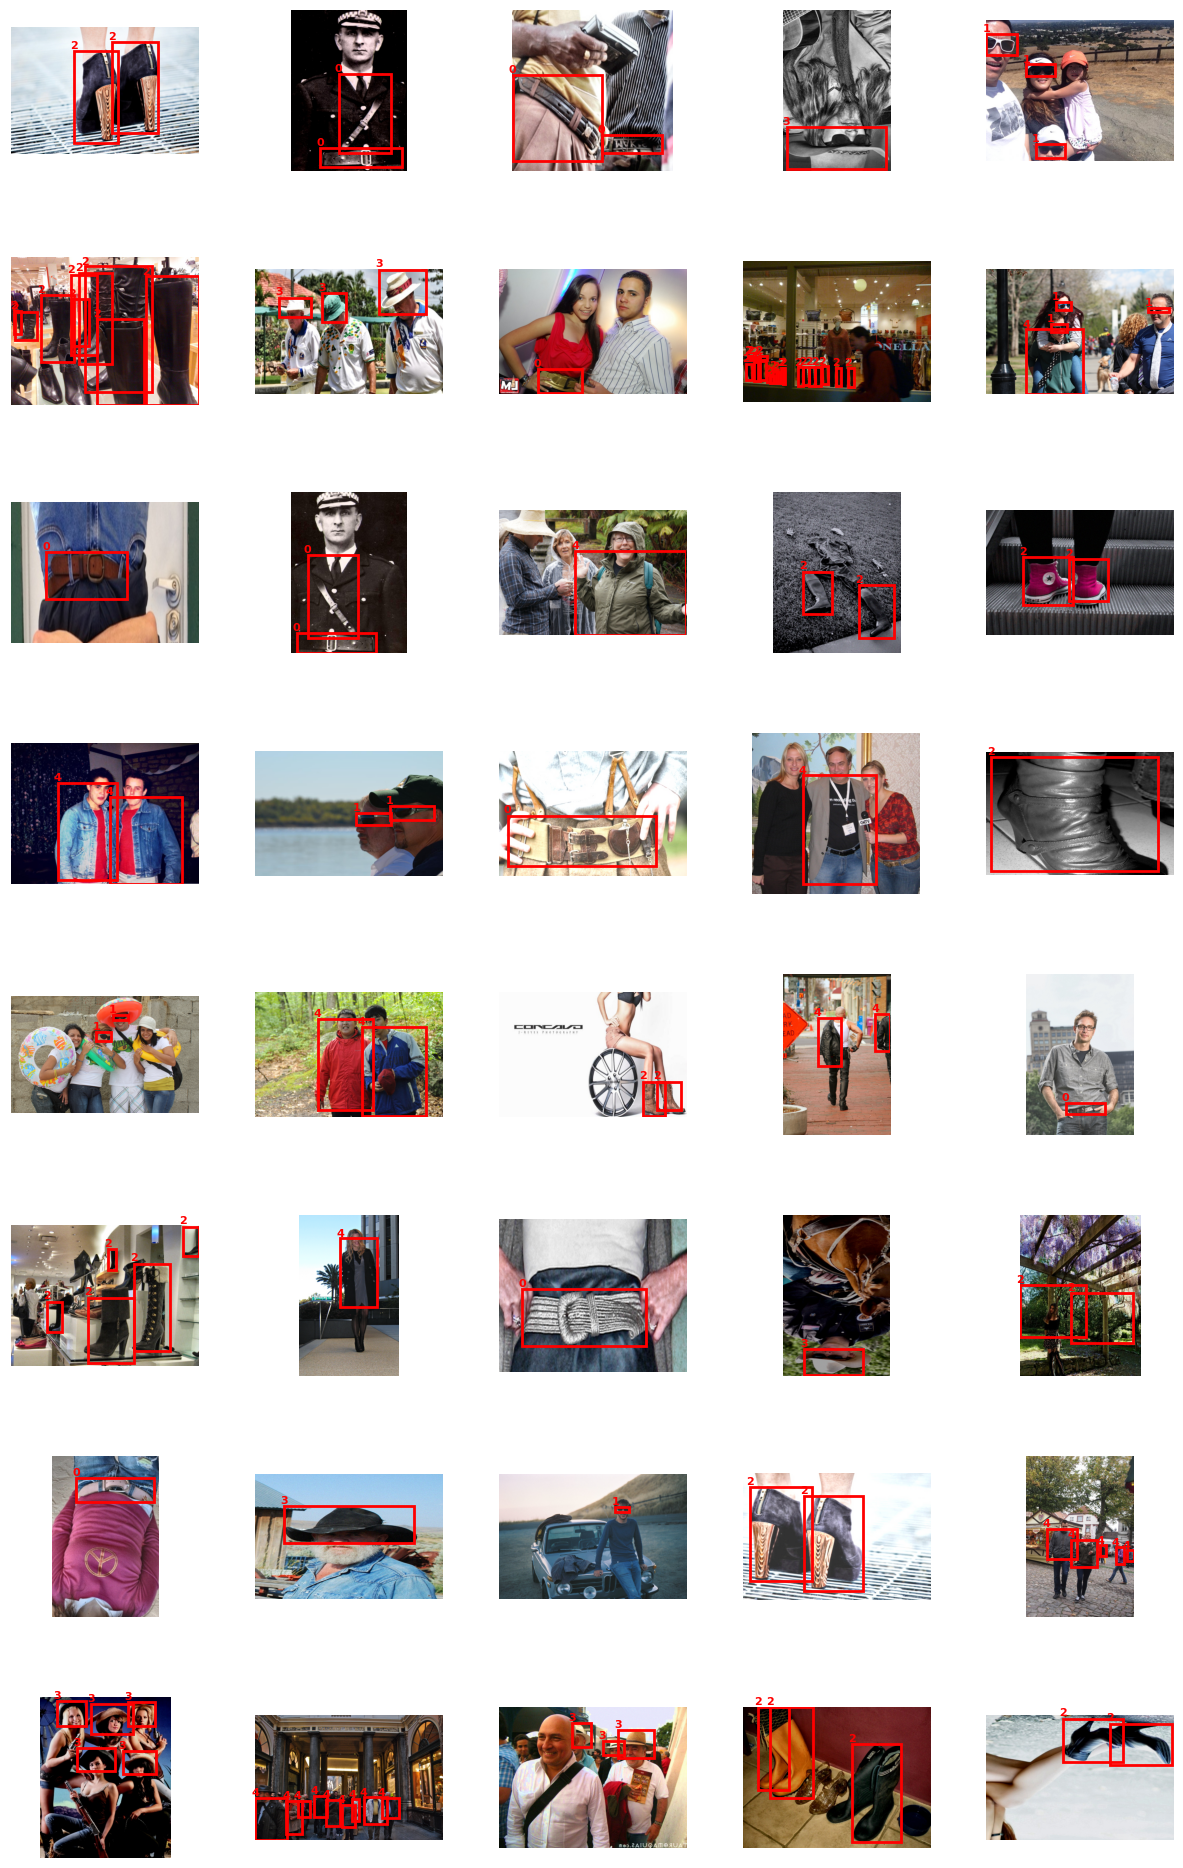

In [106]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# 设置图片和标注文件夹路径
image_dir = './data/images/val/'  # 你的训练图片路径
label_dir = './data/labels/val/'  # 你的训练标签路径

# 获取所有训练图片和标注文件名
train_images = os.listdir(image_dir)
train_labels = os.listdir(label_dir)

# 随机抽取50张图片
random_images = random.sample(train_images, 40)

# 设置绘图的行列数
rows = int(np.ceil(len(random_images) / 5))  # 向上取整计算行数
cols = 5  # 每行显示5张图片

# 调整图像显示大小，增大figsize
fig, ax = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# 如果是单行或单列的情况，将ax转为一维数组
ax = ax.flatten()

# 绘制每张图像和对应的边界框
for i, image_name in enumerate(random_images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))  # 读取相应的标签文件

    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图像: {image_path}")
        continue

    # 获取图片的宽度和高度
    h, w, _ = image.shape
    # print(h,w)
    # 读取标签文件
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
    # print(label_path)
    # 创建图像上的边界框
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 将BGR转为RGB显示
    # 绘制标签文件中的边界框
    for line in lines:

        parts = line.strip().split()
        # print(parts)
        class_id = int(parts[0])  # 类别ID
        x_center, y_center, width, height = map(float, parts[1:])

        # 计算边界框的左上角坐标和右下角坐标
        x_min = (x_center - width / 2) * w
        y_min = (y_center - height / 2) * h
        x_max = (x_center + width / 2) * w
        y_max = (y_center + height / 2) * h
        # print(f"Image: {image_name} - x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}")
        # 绘制边界框
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
                # 绘制类别标签
        ax[i].text(x_min, y_min - 10, class_id, color='red', fontsize=8, weight='bold', ha='center')

    # 标注类别（你可以根据你的类别列表来给出标签名称）
    ax[i].axis('off')

# 隐藏多余的子图
for i in range(len(random_images), len(ax)):
    ax[i].axis('off')

# 调整子图间距，防止图像过于拥挤
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# 显示图像
plt.show()
